# Linear Regression
***
## Key Points:
- Further analyse `average_playtime`
- Prepare Train and test Data Sets
- `GradientBoostingRegressor` is used to try and improve the accuracy of the model, it can handle missing values and outliers in the data and improve Variance and lower MSE.

## Making Prediction Models:
### Response:
- playtime shall be used as the response, player retention and how long they spend playing the games are good indicators for a successful game.
### Predictors:
We will explore various features:
> 1. Generic variables that happen to have highest correlation with `average_playtime`
> 2. Genres only
> 3. Features that seem important: `owners`,`overall_reviews`,`price`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

sb.set()  # set the default Seaborn style for graphics

import warnings
warnings.filterwarnings('ignore')

## 1. Importing Dataset

In [2]:
steam_df = pd.read_csv('Cleaned/steam_cleaned.csv')
print("Number of games:", len(steam_df))
steam_df.head()

Number of games: 62057


,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,01/11/2000,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,229766,5992,9847,169,10000000-20000000,10.00
1,20,Team Fortress Classic,01/04/1999,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,7005,1069,167,25,5000000-10000000,5.25
2,30,Day of Defeat,01/05/2003,1,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled;Family S...,Action,FPS;World War II;Multiplayer,6036,664,553,17,5000000-10000000,5.25
3,40,Deathmatch Classic,01/06/2001,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,2415,511,70,13,5000000-10000000,5.25
4,50,Half-Life: Opposing Force,01/11/1999,1,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,20697,1054,406,157,2000000-5000000,5.25


## quick pre-processing:
- year, individual genres and overall_reviews (genres into binarized form)
- drop unrelevant numerical data: appid

In [3]:
# convert release_date to datetime type and create separate column for release_year
steam_df['release_date'] = steam_df['release_date'].astype('datetime64[ns]')
steam_df['release_year'] = steam_df['release_date'].apply(lambda x: x.year)

# combine positive and negative review numbers for the total
steam_df = steam_df.assign(**{'overall_reviews':steam_df.positive_ratings + steam_df.negative_ratings})

#owners from range to integer
steam_df['owners'] = steam_df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

In [4]:
import re
import itertools
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.dropna().apply(lambda x: [c for c in x.split(';')]))))
# Check unique values
genres = get_unique(steam_df['genres'])

# List to store genre column names
gen_col_names = []

for gen in sorted(genres):
    # Replace spaces and special characters in genre name to create column name
    gen_name = gen.lower().replace('&', 'and').replace(' ', '_')
    gen_name = 'genre_' + gen_name
    gen_col_names.append(gen_name)
    # Create binary column for each genre
    steam_df[gen_name] = steam_df['genres'].apply(lambda x: 1 if gen in x.split(';') else 0)

# Filter out rows where none of the genres are present
gen_sums = steam_df[gen_col_names].sum(axis=1)
steam_df = steam_df[gen_sums > 0].copy()

#drop appid
steam_df.drop(columns=['appid'], inplace=True)

In [5]:
steam_df.head()

,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,positive_ratings,...,genre_racing,genre_sexual_content,genre_simulation,genre_software_training,genre_sports,genre_strategy,genre_utilities,genre_video_production,genre_violent,genre_web_publishing
0,Counter-Strike,2000-01-11,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,229766,...,0,0,0,0,0,0,0,0,0,0
1,Team Fortress Classic,1999-01-04,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Multiplayer,7005,...,0,0,0,0,0,0,0,0,0,0
2,Day of Defeat,2003-01-05,1,Valve,Valve,windows;mac;linux,Multi-player;Valve Anti-Cheat enabled;Family S...,Action,FPS;World War II;Multiplayer,6036,...,0,0,0,0,0,0,0,0,0,0
3,Deathmatch Classic,2001-01-06,1,Valve,Valve,windows;mac;linux,Multi-player;PvP;Online PvP;Shared/Split Scree...,Action,Action;FPS;Classic,2415,...,0,0,0,0,0,0,0,0,0,0
4,Half-Life: Opposing Force,1999-01-11,1,Gearbox Software,Valve,windows;mac;linux,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Classic,20697,...,0,0,0,0,0,0,0,0,0,0


In [6]:
steam_df.dtypes

name                                     object
release_date                     datetime64[ns]
english                                   int64
developer                                object
publisher                                object
platforms                                object
categories                               object
genres                                   object
steamspy_tags                            object
positive_ratings                          int64
negative_ratings                          int64
average_playtime                          int64
median_playtime                           int64
owners                                    int32
price                                   float64
release_year                              int64
overall_reviews                           int64
genre_accounting                          int64
genre_action                              int64
genre_adventure                           int64
genre_animation_and_modeling            

## Analyse `average_playtime`
- From EDA, we are aware that many games fall in 0 playtime.
- We shall use log and visuallise better.

<Axes: title={'center': 'Average Playtime (Excluding Games with Zero)'}, xlabel='average_playtime', ylabel='Density'>

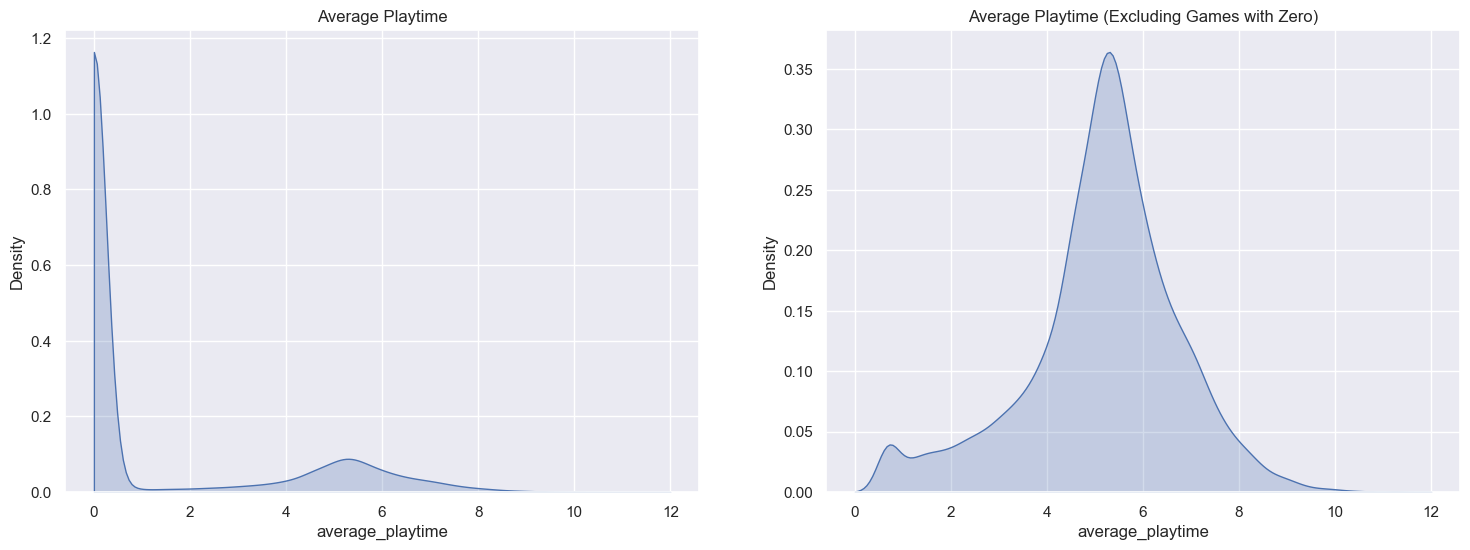

In [7]:
steam_df_exclude_zero = steam_df[steam_df.average_playtime != 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].set_title('Average Playtime')
sb.kdeplot(ax=axes[0], data=np.log(steam_df.average_playtime + 1), clip=(0.0, 12), fill=True)

axes[1].set_title('Average Playtime (Excluding Games with Zero)')
sb.kdeplot(ax=axes[1], data=np.log(steam_df_exclude_zero.average_playtime + 1), clip=(0.0, 12), fill=True)


In [8]:
# Logarithimic transformation
steam_df["average_playtime"] = np.log(steam_df.average_playtime+1)

## Finding Features
- For now, we shall have an overview of what features are most closely related with average playtime.
- Remember, we may exclude positive and negative ratings and the release year for now as we're predicting something in the future, we dont want it

In [9]:
steam_df.corr().average_playtime.sort_values(ascending = False)

average_playtime                 1.000000
median_playtime                  0.254546
price                            0.166559
owners                           0.153290
positive_ratings                 0.117429
overall_reviews                  0.117163
negative_ratings                 0.097021
genre_rpg                        0.095287
genre_strategy                   0.049599
genre_massively_multiplayer      0.048814
english                          0.042784
genre_simulation                 0.035772
genre_free_to_play               0.022099
genre_action                     0.015064
genre_web_publishing             0.014753
genre_adventure                  0.012380
genre_movie                      0.010815
genre_animation_and_modeling     0.007517
genre_photo_editing              0.007472
genre_utilities                  0.004317
genre_design_and_illustration    0.001654
genre_audio_production          -0.000553
genre_software_training         -0.000775
genre_game_development          -0

In [10]:
#abs the negative relations and see the top few with highest corr with average playtime
np.abs(steam_df.corr().average_playtime).sort_values(ascending = False).head(15)

average_playtime               1.000000
release_year                   0.310633
median_playtime                0.254546
price                          0.166559
owners                         0.153290
genre_casual                   0.130004
positive_ratings               0.117429
overall_reviews                0.117163
negative_ratings               0.097021
genre_indie                    0.095373
genre_rpg                      0.095287
genre_early_access             0.069967
genre_strategy                 0.049599
genre_massively_multiplayer    0.048814
english                        0.042784
Name: average_playtime, dtype: float64

***
# Making Models

### Response:
- playtime shall be used as the response, player retention and how long they spend playing the games are good indicators for a successful game.
### Predictors:
We will explore various features:
> **Model 1** Generic variables that happen to have highest correlation with `average_playtime`   
> **Model 2** Genres only   
> **Model 3** Features that seem important: `owners`,`overall_reviews`,`price`  
***

## Choosing Features:
- We have to take into account the predictors and response before we train
- Our predictors have to be something that is within the capabilities of the game creators: for example, cost of the game, what genre, whether it's in english.
- We will comment out median playtime, the year and both positive and negative ratings, as this is something that devlopers cannot directly predict or feed into models.

# Model 1: Variables with high correlation to average_playtime
From the section before this, we did finding features by just searching for overall correlation with the predictor.
There is a mix of genres and other variables worth exploring like english and price

In [11]:
selected_features = [
    "average_playtime",
    #"release_year",       
    #"median_playtime",
    "price",
    "owners",
    "genre_casual",
    #"positive_ratings",
    "genre_rpg",
    "genre_indie",
    #"negative_ratings",
    "genre_early_access",
    "english",
    "genre_massively_multiplayer",
    "genre_strategy",
]

temp_df = steam_df[selected_features]

predictors = temp_df.drop(columns="average_playtime")
response = temp_df.average_playtime


In [12]:
# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

### 1 Linear Regression 

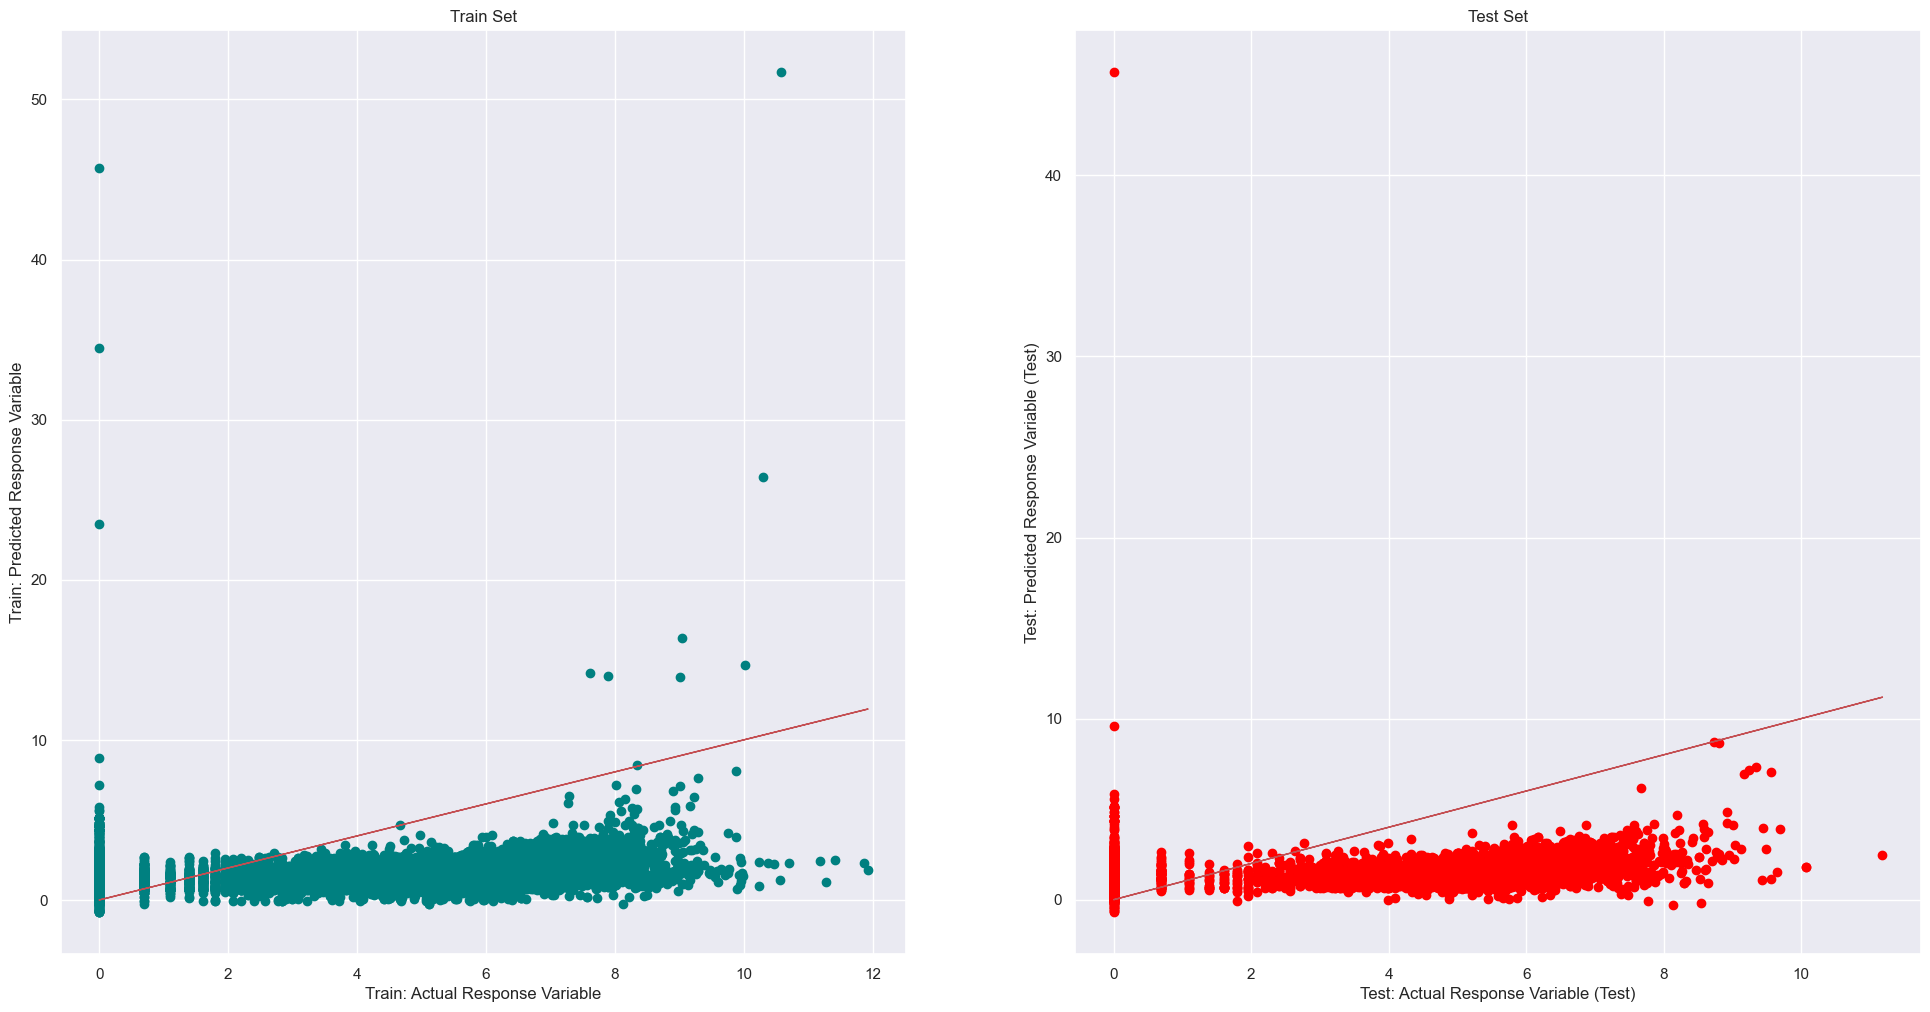

Linear Regression Model 1 Goodness of Fit:

Train Dataset:

Train Variance: 0.08649750514776988
Train Mean Square Error:  5.096174231253164

Test Dataset:

Test Variance: 0.06828544211003196
Test Mean Square Error:  4.99304938948119


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Creating the Train & Test Dataset
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.2, random_state=123)

# Training the model
reg = LinearRegression().fit(X_train, y_train)

# Linear Regression Graph
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "teal")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("Train: Actual Response Variable")
axes[0].set_ylabel("Train: Predicted Response Variable")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "red")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("Test: Actual Response Variable (Test)")
axes[1].set_ylabel("Test: Predicted Response Variable (Test)")
plt.show()

#Check Goodness of Fit
print("Linear Regression Model 1 Goodness of Fit:\n")

print("Train Dataset:\n")
print("Train Variance:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("Train Mean Square Error: ", mse_train)

print() #gap

print("Test Dataset:\n")
print("Test Variance:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("Test Mean Square Error: ", mse_test)

### 1 Creating a Model for average_playtime : GradientBoostingRegressor
`GradientBoostingRegressor` is used to try and improve the accuracy of the model.

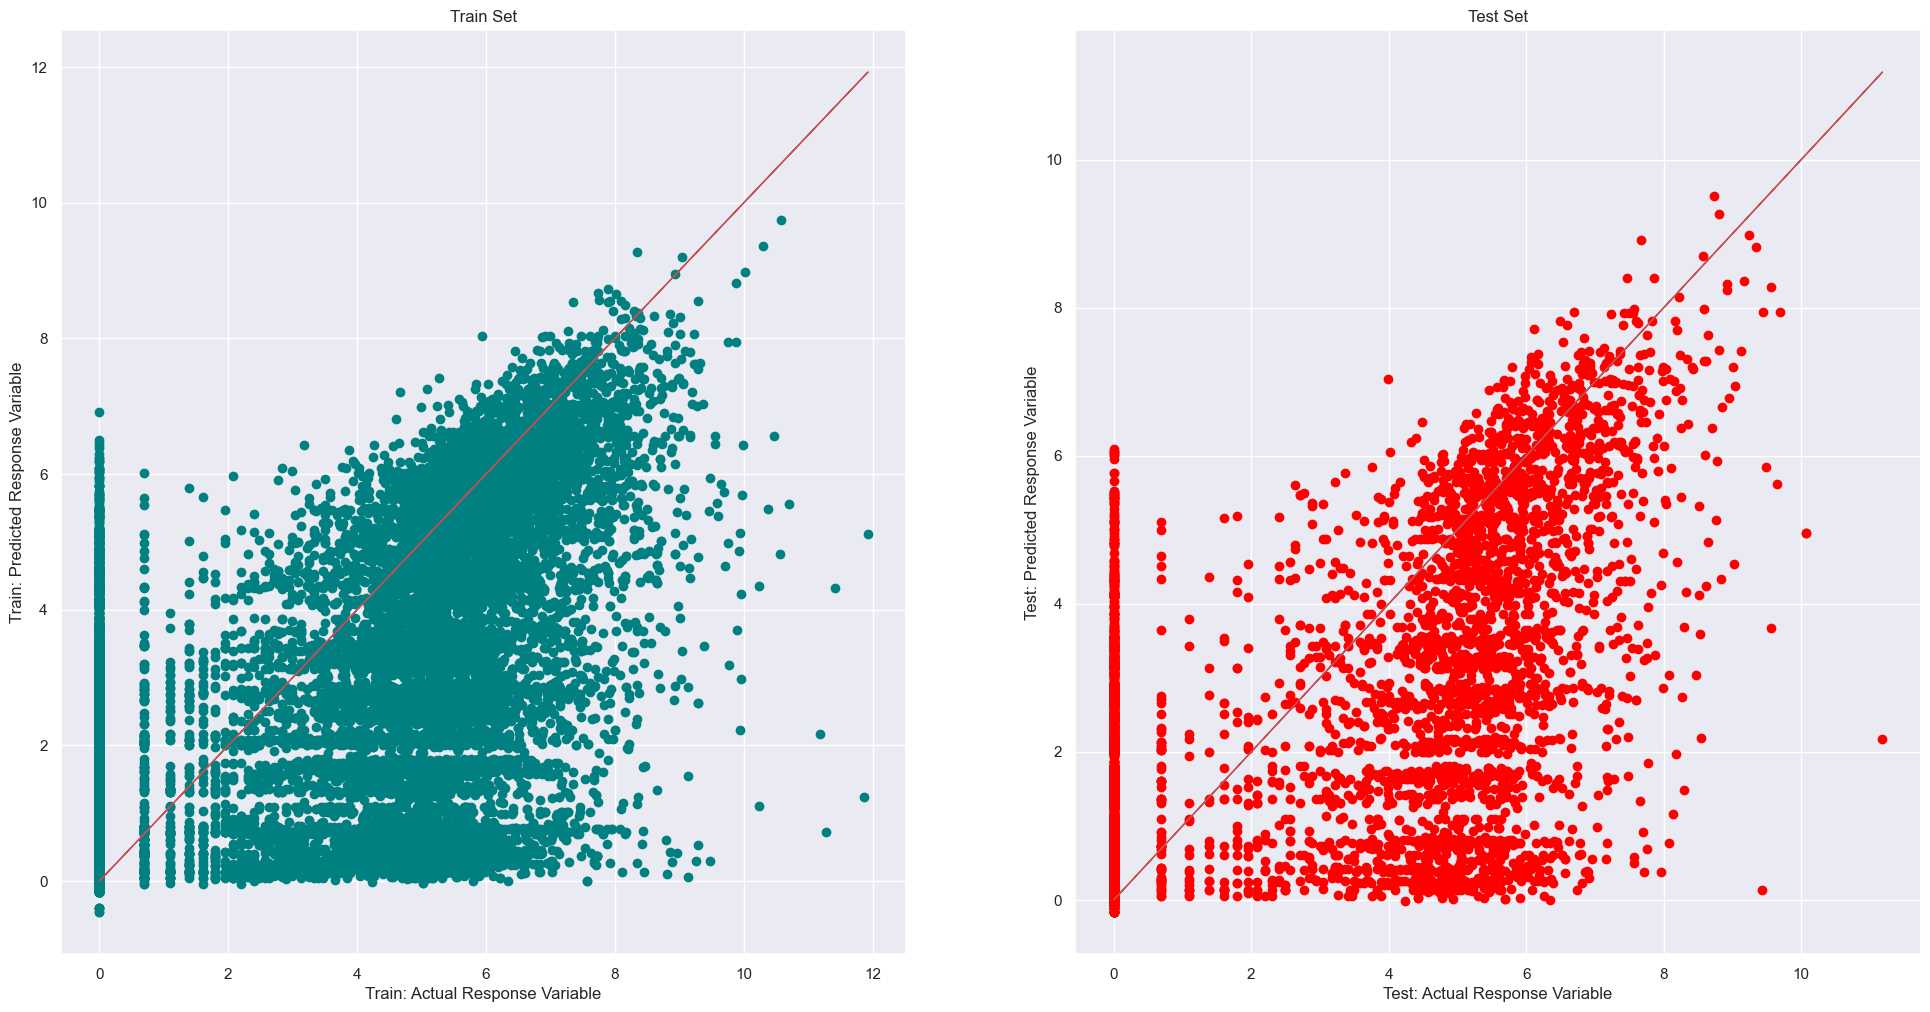

GradientBoostingRegressor Model 1 Goodness of Fit

Train Dataset:

Train Variance: 0.5402530974721877
Train Mean Square Error:  2.5647990353214056

Test Dataset:

Test Variance: 0.5333638381725132
Test Mean Square Error:  2.500698720645873


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

# Gradient Boost Regression Graph with tuned parameters 
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "teal")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("Train: Actual Response Variable")
axes[0].set_ylabel("Train: Predicted Response Variable")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "red")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("Test: Actual Response Variable")
axes[1].set_ylabel("Test: Predicted Response Variable")
plt.show()

#Check Goodness of Fit
print("GradientBoostingRegressor Model 1 Goodness of Fit\n")

print("Train Dataset:\n")
print("Train Variance:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("Train Mean Square Error: ", mse_train)

print() #gap

print("Test Dataset:\n")
print("Test Variance:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("Test Mean Square Error: ", mse_test)

# Model 1 Observation:
**~0.5 Variance**,and much lowered Mean Squared Error not bad! (After Gradient Boosting)
- Could be better, maybe better refine selected features?
- Narrowed down features done in Model 2 and 3

***

# Model 2: Try Genres Features Only 
- In our EDA, we wanted to analyse genres.
- As explored in clustering, maybe genres may not really be a good indicator, but we shall try out with regression and playtime.

In [15]:
selected_features = [
    "average_playtime",
    # Try Genre
    "genre_action",
    "genre_adventure",
    "genre_animation_and_modeling",
    "genre_audio_production",                    
    "genre_casual",                              
    "genre_design_and_illustration",              
    "genre_early_access",                         
    "genre_education",                            
    "genre_free_to_play",                         
    "genre_game_development",                     
    "genre_gore",                                 
    "genre_indie",                                
    "genre_massively_multiplayer",                
    "genre_movie",                                
    "genre_nudity",                               
    "genre_photo_editing",                        
    "genre_rpg",                                  
    "genre_racing",                              
    "genre_sexual_content",                      
    "genre_simulation",                          
    "genre_software_training",                  
    "genre_sports",                             
    "genre_strategy",                          
    "genre_utilities",                          
    "genre_video_production",                    
    "genre_violent",                            
    "genre_web_publishing"    

]

temp_df = steam_df[selected_features]

predictors = temp_df.drop(columns="average_playtime")
response = temp_df.average_playtime

### 2 Linear Regression 

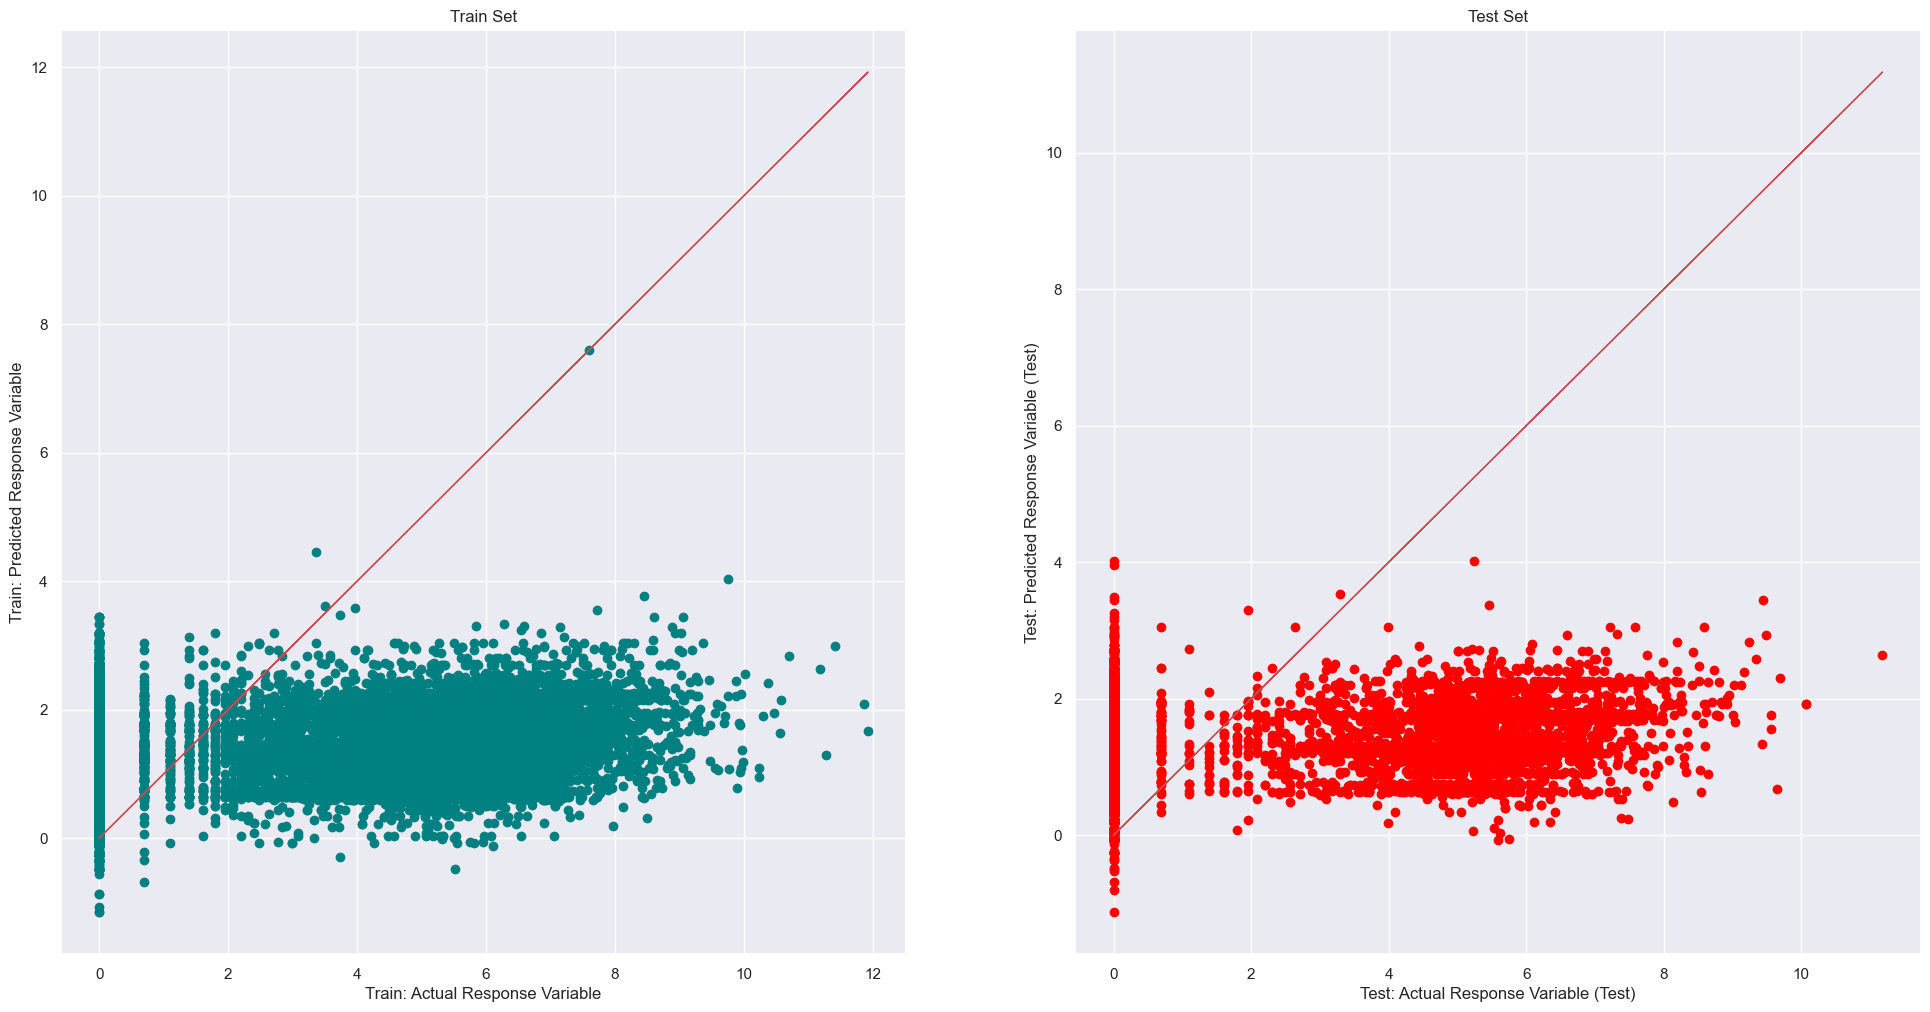

Linear Regression Model 2 Goodness of Fit:

Train Dataset:

Train Variance: 0.046506339006501474
Train Mean Square Error:  5.319273731818692

Test Dataset:

Test Variance: 0.04179761907601143
Test Mean Square Error:  5.134997379355059


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Creating the Train & Test Dataset
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.2, random_state=123)

# Training the model
reg = LinearRegression().fit(X_train, y_train)

# Linear Regression Graph
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "teal")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("Train: Actual Response Variable")
axes[0].set_ylabel("Train: Predicted Response Variable")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "red")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("Test: Actual Response Variable (Test)")
axes[1].set_ylabel("Test: Predicted Response Variable (Test)")
plt.show()

#Check Goodness of Fit
print("Linear Regression Model 2 Goodness of Fit:\n")

print("Train Dataset:\n")
print("Train Variance:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("Train Mean Square Error: ", mse_train)

print() #gap

print("Test Dataset:\n")
print("Test Variance:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("Test Mean Square Error: ", mse_test)

### Creating a Model for average_playtime : GradientBoostingRegressor
`GradientBoostingRegressor` is used to try and improve the accuracy of the model.

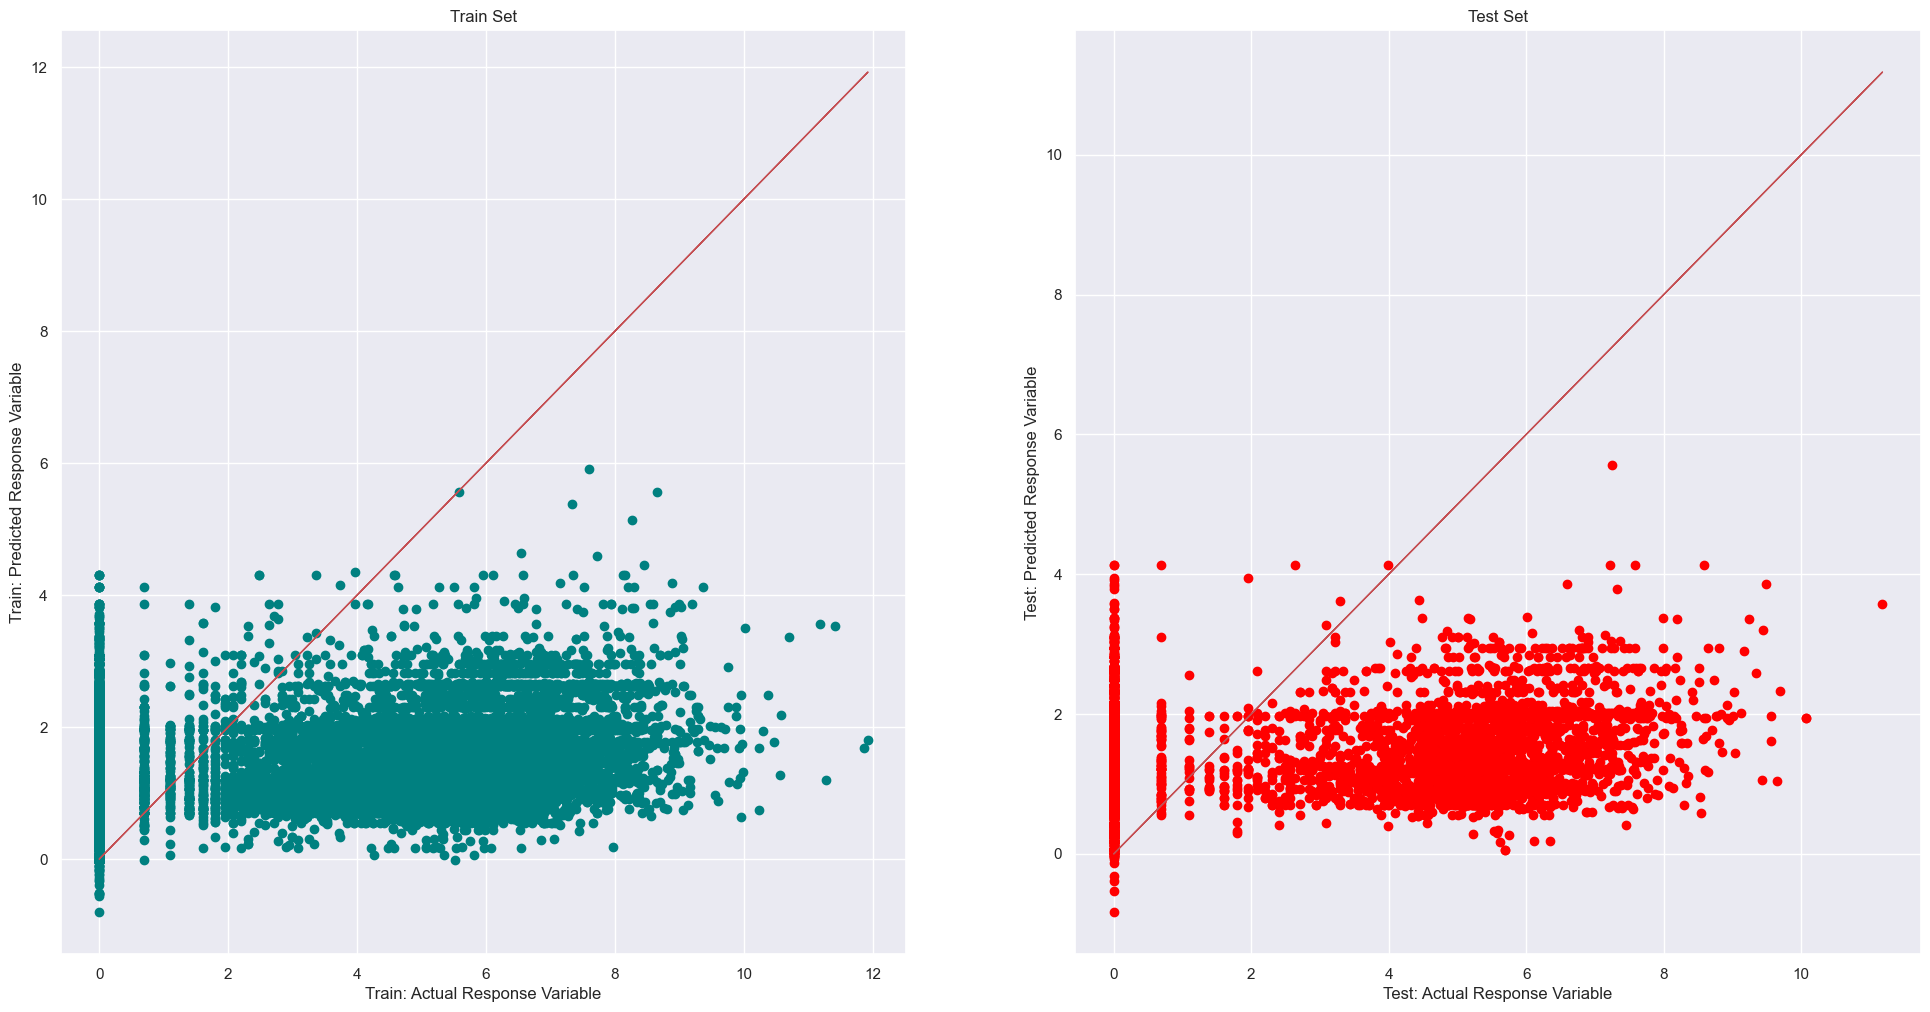

GradientBoostingRegressor Model 2 Goodness of Fit

Train Dataset:

Train Variance: 0.06278718730242083
Train Mean Square Error:  5.228447445063965

Test Dataset:

Test Variance: 0.05515508501402522
Test Mean Square Error:  5.06341484736387


In [17]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

# Gradient Boost Regression Graph with tuned parameters 
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "teal")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("Train: Actual Response Variable")
axes[0].set_ylabel("Train: Predicted Response Variable")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "red")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("Test: Actual Response Variable")
axes[1].set_ylabel("Test: Predicted Response Variable")
plt.show()

#Check Goodness of Fit
print("GradientBoostingRegressor Model 2 Goodness of Fit\n")

print("Train Dataset:\n")
print("Train Variance:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("Train Mean Square Error: ", mse_train)

print() #gap

print("Test Dataset:\n")
print("Test Variance:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("Test Mean Square Error: ", mse_test)

# Model 2 Observation:
- **Variance under 0.1** Not very good... (Even after gradient Boosting, variance "improved" from ~0.04 to ~0.06)
- Overall genres may not be a good factor in predicting a game's success.
- Not surprised, as exploredin Clustering, we also learnt that genres may not be a good indicator
- Besides trying to target a genre/tag segment, developers should focus on other variables maybe?

***

# Model 3 Features that seem important: `owners`,`overall_reviews`,`price`

In [18]:
selected_features = [
    "average_playtime",
    "owners",
    "overall_reviews",
    "price"
]

temp_df = steam_df[selected_features]

predictors = temp_df.drop(columns="average_playtime")
response = temp_df.average_playtime


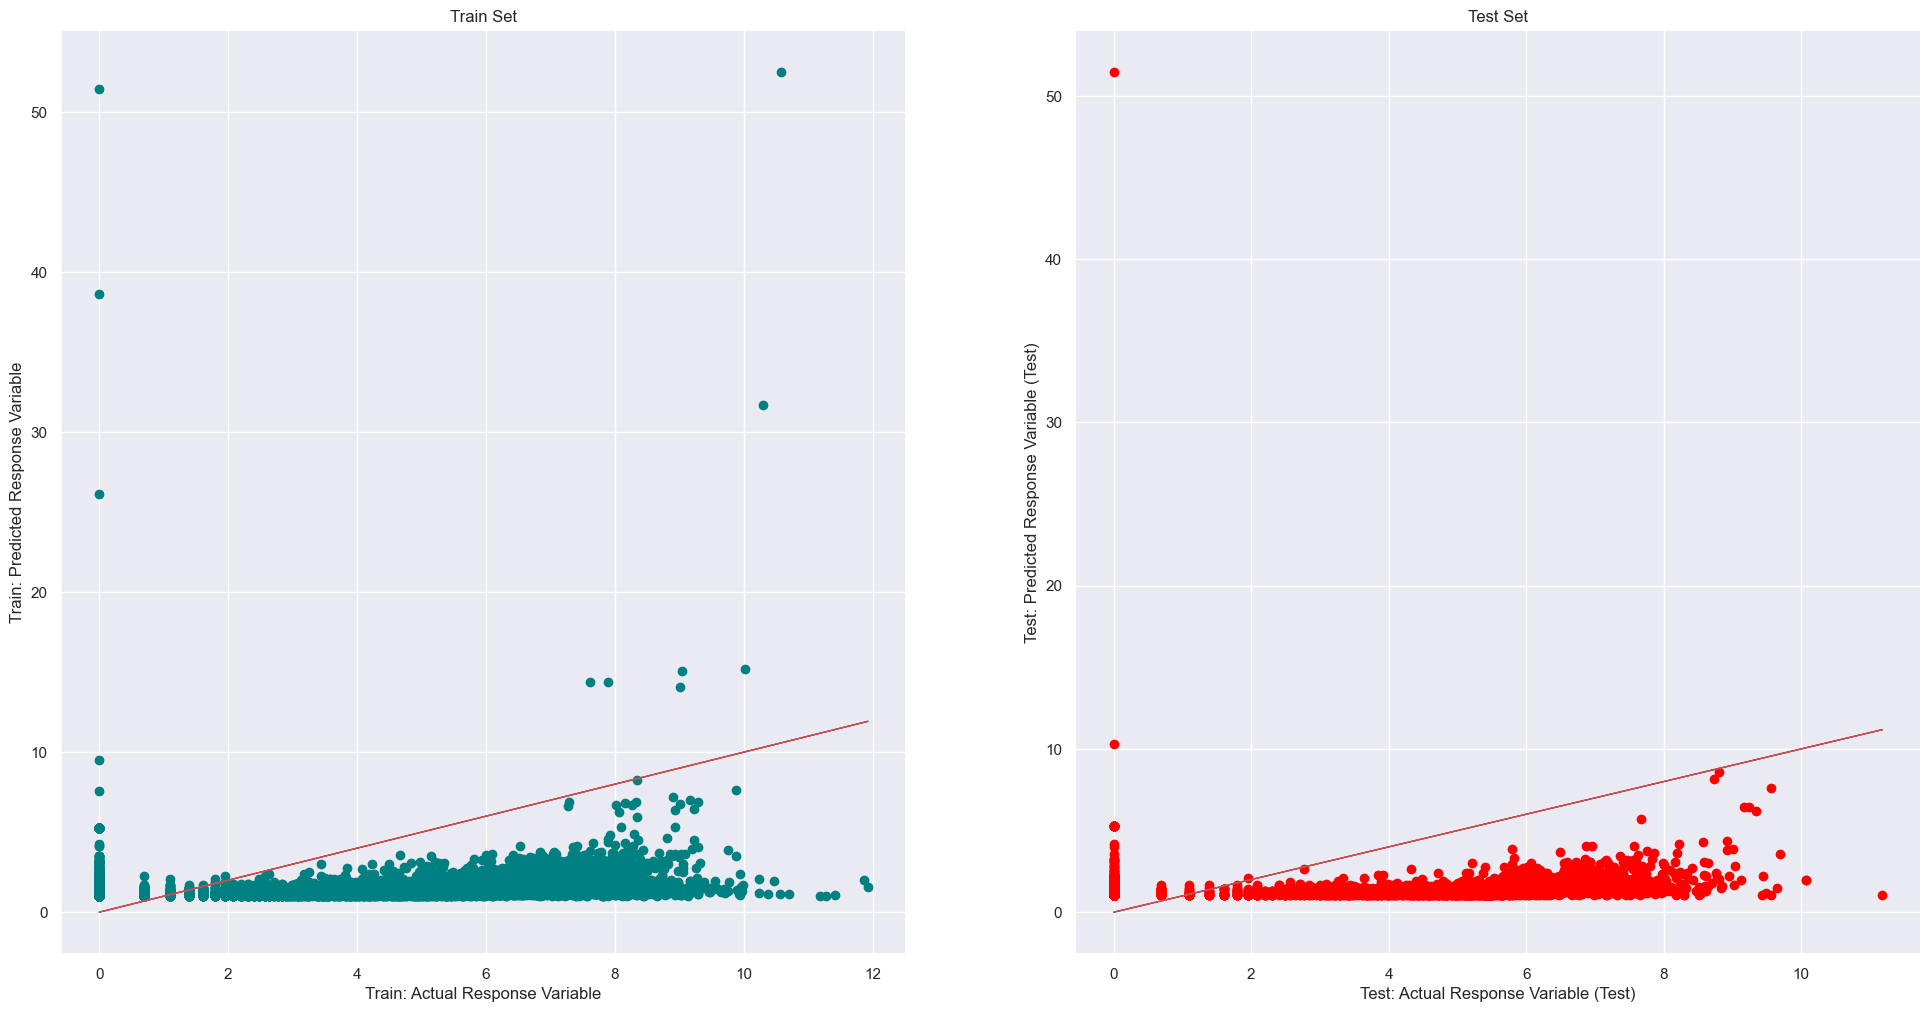

Linear Regression Model 3 Goodness of Fit:

Train Dataset:

Train Variance: 0.052081627543885234
Train Mean Square Error:  5.288170760632376

Test Dataset:

Test Variance: 0.03423966664710554
Test Mean Square Error:  5.175500374012928


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Creating the Train & Test Dataset
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.2, random_state=123)

# Training the model
reg = LinearRegression().fit(X_train, y_train)

# Linear Regression Graph
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "teal")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("Train: Actual Response Variable")
axes[0].set_ylabel("Train: Predicted Response Variable")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "red")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("Test: Actual Response Variable (Test)")
axes[1].set_ylabel("Test: Predicted Response Variable (Test)")
plt.show()

#Check Goodness of Fit
print("Linear Regression Model 3 Goodness of Fit:\n")

print("Train Dataset:\n")
print("Train Variance:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("Train Mean Square Error: ", mse_train)

print() #gap

print("Test Dataset:\n")
print("Test Variance:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("Test Mean Square Error: ", mse_test)

### Creating a Model for average_playtime : GradientBoostingRegressor
`GradientBoostingRegressor` is used to try and improve the accuracy of the model.

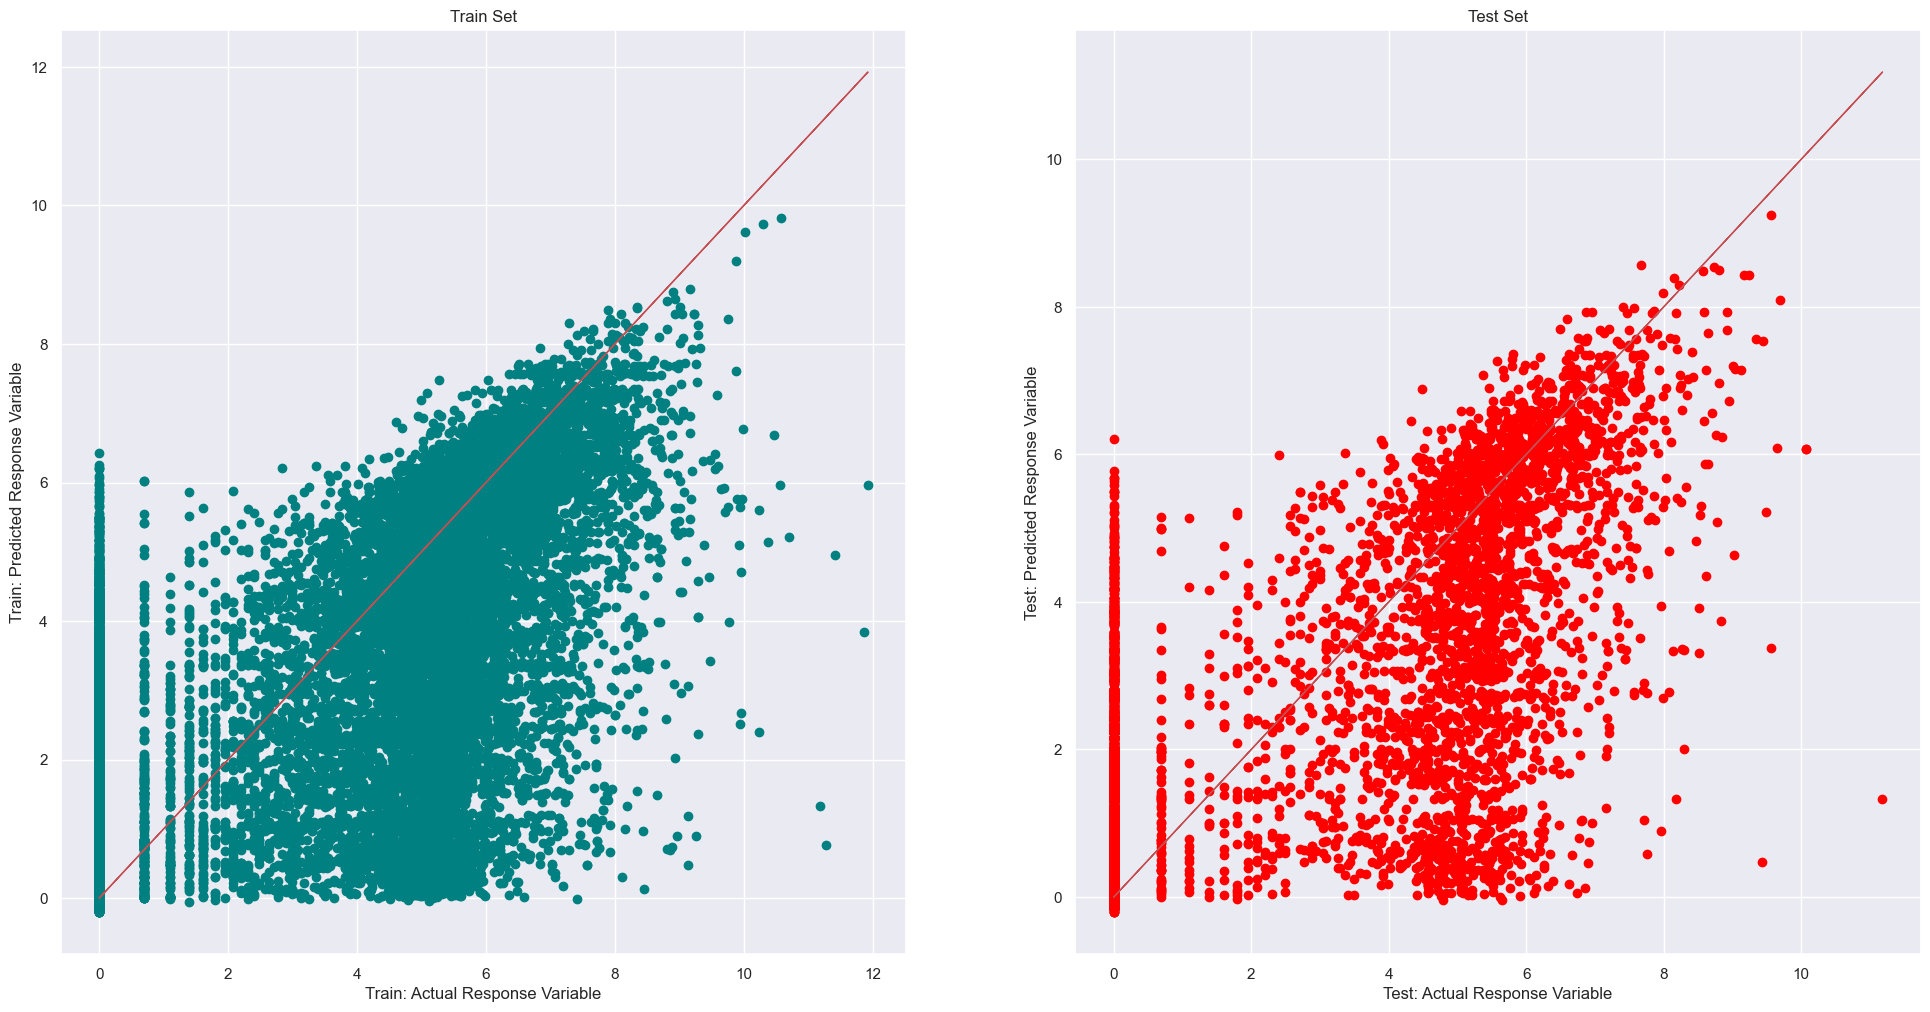

GradientBoostingRegressor Model 3 Goodness of Fit

Train Dataset:

Train Variance: 0.6517621514216283
Train Mean Square Error:  1.9427212955332043

Test Dataset:

Test Variance: 0.6439278694844317
Test Mean Square Error:  1.9081871360992368


In [20]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

# Gradient Boost Regression Graph with tuned parameters 
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "teal")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("Train: Actual Response Variable")
axes[0].set_ylabel("Train: Predicted Response Variable")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "red")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("Test: Actual Response Variable")
axes[1].set_ylabel("Test: Predicted Response Variable")
plt.show()

#Check Goodness of Fit
print("GradientBoostingRegressor Model 3 Goodness of Fit\n")

print("Train Dataset:\n")
print("Train Variance:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("Train Mean Square Error: ", mse_train)

print() #gap

print("Test Dataset:\n")
print("Test Variance:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("Test Mean Square Error: ", mse_test)

# Model 3 Observation:
- **~0.65 Variance** and **reduced Mean Square error**, not bad! (After Gradient Boosting)
- Model 3 is the best model so far.

***
# Analysis and Takeaways:

## Model 1 -  Generic variables that happen to have highest correlation with average_playtime (Moderate Variance ~0.50)
**Purpose of the model**: Its a mix of genres and seemlingly important factors like (owners, prices, english) that seem to be worth exploring. The first model is just an overview of what factors may cause better player retention, longer playtime.

From there, we can focus on two different models. One that is genre based, and one that narrows down to non-genres and practicalities (e.g overall reviews, price)

## Model 2 - Only Genres (Low Variance ~0.05, under 0.01)
**Diverse Player Preferences**: 
- Video game genres cater to a wide range of player preferences and gaming experiences. 
- Some players may prefer short, intense sessions offered by action-packed games, while others may enjoy the immersive storytelling of role-playing games (RPGs) that lead to longer playtimes. 
- The diversity in player preferences leads to varying average playtimes across different genres, resulting in a weaker correlation between genre and playtime.

**Individual Gameplay Factors**: 
- Average playtime can be influenced by various factors within each game, such as game mechanics, storyline complexity, multiplayer features, and replayability. 
- These factors can vary widely within the same genre. For example, within the action genre, one game may prioritize short, challenging levels, while another may offer an open-world experience with endless exploration opportunities. 
- This variability contributes to the low variance in the correlation between genre and playtime.

**Player Engagement and Enjoyment**: 
- Average playtime is also influenced by player engagement and enjoyment, which are subjective and multifaceted aspects of the gaming experience.
- A player's enjoyment of a game can depend on factors like graphics, music, community interaction, and personal preferences, rather than solely on the game's genre. 
- As a result, players may spend varying amounts of time playing games within the same genre, leading to a weaker correlation between genre and playtime.

## Model 3 - `owners` ,  `overall_reviews` , `price` (Moderate High Variance ~0.65)
**Owners and Average Playtime**: 
- Games with a larger number of owners tend to have higher average playtimes. 
- This could be because popular games attract more players and engagement over time. 
- Players may also spend more time playing games that have a larger player base due to competitive aspects, or community-driven content.

**Overall Reviews and Average Playtime**: 
- Games with more overall reviews, which can be indicative of popularity or player engagement, tend to have higher average playtimes. 
- Positive reviews might encourage more players to try the game, leading to longer play sessions or more frequent play. Conversely, negative reviews might deter players, resulting in shorter playtimes. 

**Price and Average Playtime**: 
- The relationship between price and average playtime can vary. 
- Generally, lower-priced games may attract more players due to affordability, potentially resulting in longer playtimes.  
- On the other hand, higher-priced games may have dedicated fan bases or offer premium content, leading to longer play sessions despite the higher cost. 
- Players may perceive higher-priced games as having higher value, motivating them to spend more time playing to justify the investment.
